## Transformer

Python: 3.9.10

In [ ]:
# !pip3 install torch
# !pip3 install numpy==1.23.5
# !pip3 install transformers --no-cache-dir
# !pip3 install -q datasets
# !pip3 install --upgrade scikit-learn==1.0.2
# !pip3 install matplotlib
# !pip3 install accelerate -U
# !pip3 install seaborn

In [ ]:
# !pip3 install datasets

In [ ]:
# !pip3 install ipywidgets

In [ ]:
# !pip3 install -U "huggingface_hub[hf_xet]"

Sanity test: Is AutoTokenizer working correctly?

In [ ]:
import numpy
from transformers import AutoTokenizer
print("NumPy version:", numpy.__version__)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Sanity test: GPU detected by torch?

Uninstall PyTorch (CPU-only) and install GPU-enabled PyTorch

In [ ]:
# %pip install torch --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import torch
print(torch.cuda.is_available())       # Should be True
print(torch.cuda.device_count())       # Should be > 0
print(torch.cuda.get_device_name(0))   # Should show your GPU name
print(torch.__version__)                # Confirms the install
print(torch.version.cuda)               # Shows the CUDA version used

### Initial Steps

In [2]:
import torch
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict

from sklearn.metrics import classification_report, confusion_matrix

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Loading the dataset:

In [4]:
from datasets import load_dataset

dataset = load_dataset("derek-thomas/ScienceQA")

In [5]:
import pandas as pd

# Function to convert each split
def prepare_dataset_for_classification(dataset, split_name, column_to_classify, target_classes=[], data_fields=[], shuffle=True, random_state=None, max_items_per_class=None):
    # Load into DataFrame
    df = pd.DataFrame(dataset[split_name])

     # Filter only rows with target topics
    df = df[df[column_to_classify].isin(target_classes)].reset_index(drop=True)

     # Optionally limit the number of items per class
    if max_items_per_class is not None:
        dfs = []
        for cls in target_classes:
            subset = df[df[column_to_classify] == cls]
            sampled = subset.sample(
                n=min(len(subset), max_items_per_class),
                random_state=random_state
            )
            dfs.append(sampled)

        df = pd.concat(dfs).reset_index(drop=True)

    # Shuffle if requested
    if shuffle:
        df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Handle text combination from selected fields
    processed_fields = []
    for field in data_fields:
        if field == 'choices':
            processed = df['choices'].apply(lambda x: " ".join(x))
        elif field == 'answer':
            # Get the string value from choices[answer]
            def get_answer(row):
                try:
                    return row['choices'][row['answer']] if isinstance(row['choices'], list) else ""
                except (IndexError, TypeError):
                    return ""
            processed = df.apply(get_answer, axis=1)
        else:
            processed = df[field].fillna("")
        processed_fields.append(processed)

    # Concatenate all fields into a single string per row
    data = processed_fields[0]
    for pf in processed_fields[1:]:
        data = data + " " + pf
    data = data.tolist()
    
    # Create label info
    target = [target_classes.index(_class_) for _class_ in df[column_to_classify]]
    
    return {
        'data': data,
        'target': target,
        'target_names': target_classes
    }

    # data = (df['question'] + ' ' + df['lecture'] + ' ' + df['choices'].apply(lambda x: " ".join(x)) + ' ' + df['hint'].fillna('')).tolist()

### Topic Classification

Getting the topics:

All topics

In [ ]:
# Function to collect unique values from a field
def get_unique_values(dataset, field):
    return sorted(set(example[field] for example in dataset))

train_set = dataset["train"]

# Get unique values
target_topics = get_unique_values(train_set, "topic")

# Display them
print("Topics:", target_topics)

In [131]:
# Define your target topics (e.g., 4 of them)
target_topics = ['biology', 'physics', 'geography', 'writing-strategies', 'figurative-language', 'chemistry', 'earth-science']

In [132]:
data_fields = ['question', 'answer', 'hint', 'solution', 'lecture']
# data_fields = ['question']

In [135]:
# Process each set
sets = {
    "train": prepare_dataset_for_classification(dataset, "train", "topic", target_topics, data_fields,  shuffle=False, random_state=12, max_items_per_class=300),
    "validation": prepare_dataset_for_classification(dataset, "validation", "topic", target_topics, data_fields,  shuffle=False, random_state=12, max_items_per_class=200),
    "test": prepare_dataset_for_classification(dataset, "test", "topic", target_topics, data_fields,  shuffle=False, random_state=12, max_items_per_class=300)
}

Distribution of data across the topics

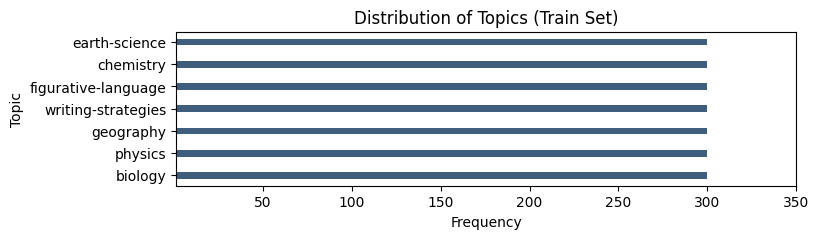

biology: 300
physics: 300
geography: 300
writing-strategies: 300
figurative-language: 300
chemistry: 300
earth-science: 300


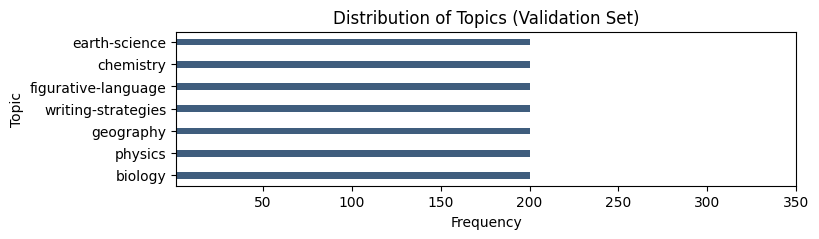

biology: 200
physics: 200
geography: 200
writing-strategies: 200
figurative-language: 200
chemistry: 200
earth-science: 200


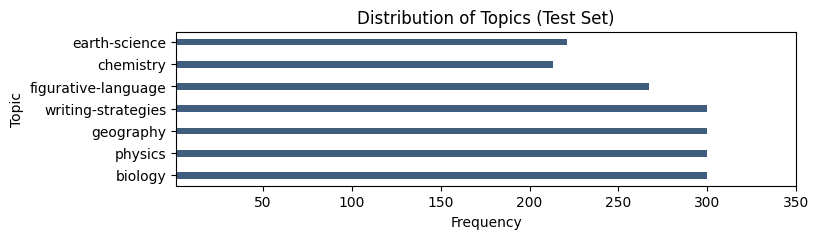

biology: 300
physics: 300
geography: 300
writing-strategies: 300
figurative-language: 267
chemistry: 213
earth-science: 221


In [136]:
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

def plot_distribution(set_name):
    counts = Counter(sets[set_name]['target'])
    topic_names = [sets[set_name]['target_names'][i] for i in counts.keys()]

    plt.figure(figsize=(8, 2))
    plt.barh(topic_names, counts.values(), height=0.3, color="#3F5D7D")
    plt.xlim([1, 350])
    plt.xlabel('Frequency')
    plt.ylabel('Topic')
    plt.title(f'Distribution of Topics ({set_name.capitalize()} Set)')
    plt.show()

    for i in counts.keys():
        print(f"{sets[set_name]['target_names'][i]}: {counts[i]}")

# Plot for all three sets
for split in ['train', 'validation', 'test']:
    plot_distribution(split)

### Creating a model and preprocessing data

In [137]:
model_name = 'bert-base-uncased'

In [138]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [139]:
from transformers import AutoModelForSequenceClassification

# config = BertConfig.from_pretrained('bert-base-uncased', force_download=True)
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(target_topics),
    # force_download=True
)
# model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')

print(model.config.to_dict())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': 'float32', 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'chunk_size_feed_forward': 0, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'typical_p': 1.0, 'repetition_penalty': 1.0, 'length_penalty': 1.0, 'no_repeat_ngram_size': 0, 'encoder_no_repeat_ngram_size': 0, 'bad_words_ids': None, 'num_return_sequences': 1, 'output_scores': False, 'return_dict_in_generate': False, 'forced_bos_token_id': None, 'forced_eos_token_id': None, 'remove_invalid_values': False, 'exponential_decay_length_penalty': None, 'suppress_tokens': None, 'begin_supp

In [140]:
model = model.to(device)

In [141]:
n_params = sum(param.numel() for param in model.parameters())
n_params

109487623

In [142]:
model.bert.config

BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [17]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter shape: {param.size()}")
    print(f"Is trainable: {param.requires_grad}")
    print()

Parameter name: bert.embeddings.word_embeddings.weight
Parameter shape: torch.Size([30522, 768])
Is trainable: True

Parameter name: bert.embeddings.position_embeddings.weight
Parameter shape: torch.Size([512, 768])
Is trainable: True

Parameter name: bert.embeddings.token_type_embeddings.weight
Parameter shape: torch.Size([2, 768])
Is trainable: True

Parameter name: bert.embeddings.LayerNorm.weight
Parameter shape: torch.Size([768])
Is trainable: True

Parameter name: bert.embeddings.LayerNorm.bias
Parameter shape: torch.Size([768])
Is trainable: True

Parameter name: bert.encoder.layer.0.attention.self.query.weight
Parameter shape: torch.Size([768, 768])
Is trainable: True

Parameter name: bert.encoder.layer.0.attention.self.query.bias
Parameter shape: torch.Size([768])
Is trainable: True

Parameter name: bert.encoder.layer.0.attention.self.key.weight
Parameter shape: torch.Size([768, 768])
Is trainable: True

Parameter name: bert.encoder.layer.0.attention.self.key.bias
Parameter sh

In [18]:
print("vocabulary size: ", len(tokenizer.vocab))

vocabulary size:  30522


In [19]:
example_text = "I always wondered what those Transformer models were doing to my text. Here is a OutOfVocabWord."
encoded_text = tokenizer(example_text).input_ids
vocab_terms = list(tokenizer.vocab.keys())
vocab_index = list(tokenizer.vocab.values())
print("input text: "+example_text)
print("tokenized:  ", [vocab_terms[vocab_index.index(i)] for i in encoded_text])

input text: I always wondered what those Transformer models were doing to my text. Here is a OutOfVocabWord.
tokenized:   ['[CLS]', 'i', 'always', 'wondered', 'what', 'those', 'transform', '##er', 'models', 'were', 'doing', 'to', 'my', 'text', '.', 'here', 'is', 'a', 'out', '##of', '##vo', '##ca', '##b', '##word', '.', '[SEP]']


In [143]:
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(sets['train']['data'], sets['train']['target'])]
validation_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(sets['validation']['data'], sets['validation']['target'])]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(sets['test']['data'], sets['test']['target'])]

In [144]:
train_data = Dataset.from_list(train_data)
validation_data = Dataset.from_list(validation_data)
test_data = Dataset.from_list(test_data)

In [145]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = validation_data
data['test'] = test_data

In [146]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True,)

tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1901 [00:00<?, ? examples/s]

In [25]:
sets['train']['data'][0]

"Based on this information, what is Fang's phenotype for the coat pattern trait?"

In [26]:
tokenized_data['train'][0].keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

In [27]:
print(tokenized_data['train'][0]['input_ids'])

[101, 2241, 2006, 2023, 2592, 1010, 2054, 2003, 15197, 1005, 1055, 6887, 16515, 13874, 2005, 1996, 5435, 5418, 18275, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
len(tokenized_data['train'][0]['input_ids'])

143

In [29]:
print(tokenized_data['train'][0]['label'])

0


### Training the model

In [147]:
import os
os.environ["WANDB_DISABLED"] = "true"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["TORCH_USE_CUDA_DSA"] = "true"

In [148]:
training_args = TrainingArguments(
    "7_LABELS_BERT_B",
    report_to=None,                        # Disabling wandb callbacks
    num_train_epochs=1,                    # Epochs - start with fewer epochs for fast training
    per_device_train_batch_size=8,         # Small batch size due to limited GPU memory
    per_device_eval_batch_size=16,         # Larger batch size for evaluation
    gradient_accumulation_steps=4,         # Accumulate gradients to simulate a larger batch size
    eval_strategy="steps",                 # Evaluate at the end of every epoch
    save_strategy="steps",                 # Evaluate at the end of every epoch
    logging_dir="./logs",                  # Directory for logging
    logging_steps=10,                     # Log every 100 steps
    learning_rate=2e-5,                    # Standard learning rate for fine-tuning BERT
    weight_decay=0.01,                     # Regularization to prevent overfitting
    adam_epsilon=1e-8,                     # Adam optimizer epsilon
    fp16=True,                             # Enable mixed precision (FP16)
    load_best_model_at_end=True,           # Load the best model based on evaluation metrics
    metric_for_best_model="eval_loss",      # Choose evaluation metric to monitor for early stopping
    dataloader_num_workers=2,              # Use a couple of workers for data loading (adjust based on CPU cores)
    dataloader_pin_memory=True            # Pin memory for faster data loading       
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [149]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
    data_collator=data_collator,
)

In [150]:
trainer.train()

Step,Training Loss,Validation Loss
10,1.841700,1.655637
20,1.620800,1.464912
30,1.379500,1.274330
40,1.267000,1.148315
50,1.138100,1.054762
60,1.060600,0.985107


TrainOutput(global_step=65, training_loss=1.3579817551832933, metrics={'train_runtime': 5291.512, 'train_samples_per_second': 0.397, 'train_steps_per_second': 0.012, 'total_flos': 547295563776000.0, 'train_loss': 1.3579817551832933, 'epoch': 0.9885931558935361})

In [38]:
print(set(tokenized_data['train']['label']))
print("Num labels expected:", model.config.num_labels)

{0, 1, 2, 3, 4, 5, 6}
Num labels expected: 7


### Evaluating the model

In [151]:
trainer.evaluate()

{'eval_loss': 0.9747977256774902,
 'eval_runtime': 426.2948,
 'eval_samples_per_second': 3.284,
 'eval_steps_per_second': 0.206,
 'epoch': 0.9885931558935361}

In [152]:
preds = trainer.predict(tokenized_data['test'])
preds

PredictionOutput(predictions=array([[ 1.48339844e+00, -5.03234863e-02,  3.42712402e-02, ...,
         4.44580078e-01, -9.58007812e-01,  4.07226562e-01],
       [ 1.41113281e+00, -6.56127930e-02,  1.27563477e-01, ...,
         2.07641602e-01, -9.82421875e-01,  2.87109375e-01],
       [ 1.39648438e+00, -2.74658203e-01,  4.97070312e-01, ...,
         2.64648438e-01, -7.95410156e-01,  2.43164062e-01],
       ...,
       [-2.90222168e-02,  4.06005859e-01, -9.20898438e-01, ...,
         1.09069824e-01, -2.45361328e-02,  1.34375000e+00],
       [ 8.92578125e-01,  2.88085938e-01, -3.05419922e-01, ...,
         5.84472656e-01, -7.31933594e-01,  9.78515625e-01],
       [ 8.48770142e-04,  7.54394531e-01, -4.65820312e-01, ...,
        -4.48974609e-01, -3.01025391e-01,  8.00781250e-01]], dtype=float32), label_ids=array([0, 0, 0, ..., 6, 6, 6], dtype=int64), metrics={'test_loss': 0.971559464931488, 'test_runtime': 573.5876, 'test_samples_per_second': 3.314, 'test_steps_per_second': 0.207})

In [153]:
print(tokenized_data['test']['label'])  # View the first element
print(tokenized_data['test'].column_names)  # Check the column names to ensure 'labels' exists

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [154]:
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
y_pred

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [155]:
print(classification_report(sets['test']['target'], y_pred, target_names=sets['test']['target_names']))

                     precision    recall  f1-score   support

            biology       0.92      0.99      0.95       300
            physics       0.98      0.85      0.91       300
          geography       1.00      0.98      0.99       300
 writing-strategies       0.95      0.96      0.96       300
figurative-language       0.96      1.00      0.98       267
          chemistry       0.83      1.00      0.91       213
      earth-science       0.99      0.85      0.91       221

           accuracy                           0.95      1901
          macro avg       0.95      0.95      0.94      1901
       weighted avg       0.95      0.95      0.95      1901



In [156]:
print(confusion_matrix(sets['test']['target'], y_pred))

[[297   2   1   0   0   0   0]
 [  7 254   0   3   0  36   0]
 [  3   0 294   3   0   0   0]
 [  0   0   0 288  11   0   1]
 [  0   0   0   0 267   0   0]
 [  0   1   0   0   0 212   0]
 [ 16   3   0   8   1   6 187]]


In [157]:
# Assuming 'preds' is the result of trainer.predict()
predictions, label_ids, _ = preds  # Ignore the metrics part with '_'

predictions, label_ids, metrics = preds
print("Predictions:", predictions)
print("Label IDs:", label_ids)
print("Metrics:", metrics)

# Calculate the loss using torch's cross_entropy
loss = torch.nn.functional.cross_entropy(torch.tensor(predictions), torch.tensor(label_ids), reduction='none')
loss

Predictions: [[ 1.48339844e+00 -5.03234863e-02  3.42712402e-02 ...  4.44580078e-01
  -9.58007812e-01  4.07226562e-01]
 [ 1.41113281e+00 -6.56127930e-02  1.27563477e-01 ...  2.07641602e-01
  -9.82421875e-01  2.87109375e-01]
 [ 1.39648438e+00 -2.74658203e-01  4.97070312e-01 ...  2.64648438e-01
  -7.95410156e-01  2.43164062e-01]
 ...
 [-2.90222168e-02  4.06005859e-01 -9.20898438e-01 ...  1.09069824e-01
  -2.45361328e-02  1.34375000e+00]
 [ 8.92578125e-01  2.88085938e-01 -3.05419922e-01 ...  5.84472656e-01
  -7.31933594e-01  9.78515625e-01]
 [ 8.48770142e-04  7.54394531e-01 -4.65820312e-01 ... -4.48974609e-01
  -3.01025391e-01  8.00781250e-01]]
Label IDs: [0 0 0 ... 6 6 6]
Metrics: {'test_loss': 0.971559464931488, 'test_runtime': 573.5876, 'test_samples_per_second': 3.314, 'test_steps_per_second': 0.207}


tensor([0.9377, 0.9538, 1.0095,  ..., 0.9061, 1.3998, 1.2920])

In [158]:
index_of_instance = torch.argmax(loss).item()
index_of_instance

696

In [159]:
loss[index_of_instance].item()

2.428673267364502

In [160]:
print(f'Target class:    {sets["test"]["target_names"][sets["test"]["target"][index_of_instance]]}')
print(f'Predicted class: {sets["test"]["target_names"][y_pred[index_of_instance]]}')

Target class:    geography
Predicted class: biology


In [161]:
print(sets['test']['data'][index_of_instance])

In which place are cows, horses, and other livestock more common? a rural area  Cows, horses, and other livestock are more common in rural areas. They need a lot of open space. Rural areas have a lot of open space. There aren't many buildings or people. People around the world live in three main kinds of places: urban areas, suburban areas, and rural areas.
An urban area is a city. It has many people and businesses. The buildings are close to each other. The buildings are often tall and have many floors. Since there are so many people, traffic is usually bad. People will walk or take the bus, train, or subway to avoid traffic.
A suburban area, or suburb, is near a city. It is quieter and less crowded than an urban area. People usually live in houses with yards. Most people drive to get places.
A rural area is less crowded than both urban and suburban areas. Houses are much more spread out. People usually have to drive to get places. People in rural areas often live on farms or ranches.

### Making Predictions

In [162]:
@torch.no_grad()
def predict(text):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = model(**input_encodings)

    lbl = sets['test']['target_names'][torch.argmax(outputs.logits).item()]

    return lbl

In [163]:
@torch.no_grad()
def predict_proba(text):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = model(**input_encodings)

    proba = torch.softmax(outputs.logits, dim=1).cpu().squeeze().numpy()


    return dict(zip(sets['test']['target_names'], proba))

In [165]:
sample_text = 'Prolong periods of intermediate fasting lead cells to the state of autophagy'
predict(sample_text)

'writing-strategies'

In [166]:
predict_proba(sample_text).values()

dict_values([0.21431877, 0.1324658, 0.12506446, 0.22758484, 0.09993551, 0.06880208, 0.13182859])

In [167]:
predict_proba(sample_text).keys()

dict_keys(['biology', 'physics', 'geography', 'writing-strategies', 'figurative-language', 'chemistry', 'earth-science'])

### Saving and loading a fine-tuned model

In [168]:
# Save to a directory
tokenizer.save_pretrained("./models/7-labels-bert-b")
model.save_pretrained('./models/7-labels-bert-b')

In [172]:
tokenizer = AutoTokenizer.from_pretrained("./models/7-labels-bert-b")
model = AutoModelForSequenceClassification.from_pretrained('./models/7-labels-bert-b').to(device)
predict('the distance between two points is 10km, I am traveling from point A to point B at a speed of 5km/h. How much time do I need to get from point A to point B?')

'geography'

### 1st Model

Task: **Topic Classification**

Labels: **['biology', 'physics', 'geography']**

Data consisted of these fields: **['question', 'answer', 'hint', 'solution', 'lecture']**

Training Size: **300 records per topic** 

Validation Size: **200 records per topic** 

training arguments: 
- num_train_epochs=1,                    # Epochs - start with fewer epochs for fast training
- per_device_train_batch_size=8,         # Small batch size due to limited GPU memory
- per_device_eval_batch_size=16,         # Larger batch size for evaluation
- gradient_accumulation_steps=4,         # Accumulate gradients to simulate a larger batch size
- eval_strategy="steps",                 # Evaluate at the end of every epoch
- save_strategy="steps",                 # Evaluate at the end of every epoch
- logging_dir="./logs",                  # Directory for logging
- logging_steps=10,                     # Log every 100 steps
- learning_rate=2e-5,                    # Standard learning rate for fine-tuning BERT
- weight_decay=0.01,                     # Regularization to prevent overfitting
- adam_epsilon=1e-8,                     # Adam optimizer epsilon
- fp16=True,                             # Enable mixed precision (FP16)
- load_best_model_at_end=True,           # Load the best model based on evaluation metrics
- metric_for_best_model="eval_loss",      # Choose evaluation metric to monitor for early stopping
- dataloader_num_workers=2,              # Use a couple of workers for data loading (adjust based on CPU cores)
- dataloader_pin_memory=True            # Pin memory for faster data loading

In [183]:
model_path = './models/3-labels-bert'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

In [116]:
predict('the distance between two points is 10km, I am traveling from point A to point B at a speed of 5km/h. How much time do I need to get from point A to point B?')

'geography'

In [117]:
predict('Effective writing strategies include planning, drafting, revising, and editing to clearly communicate ideas and engage the reader.')

'biology'

In [184]:
test = prepare_dataset_for_classification(
    dataset, 
    "test", 
    "topic", 
    ['biology', 'physics', 'geography'],
    ['question'],
    shuffle=True,
    random_state=None,
    max_items_per_class=300
)

testDataset = Dataset.from_dict({
    'text': test['data'],
    'label': test['target']
})

In [185]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True,)

tokenized_testingData = testDataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

In [186]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments()

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\chris\AppData\Local\Temp\ipykernel_16920\1057010216.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [187]:
preds = trainer.predict(tokenized_testingData)

Classification Report:


,precision,recall,f1-score,support
biology,0.99,0.95,0.97,300.00
physics,0.99,0.81,0.89,300.00
geography,0.82,1.00,0.90,300.00
accuracy,0.92,0.92,0.92,0.92
macro avg,0.93,0.92,0.92,900.00
weighted avg,0.93,0.92,0.92,900.00


Confusion Matrix:


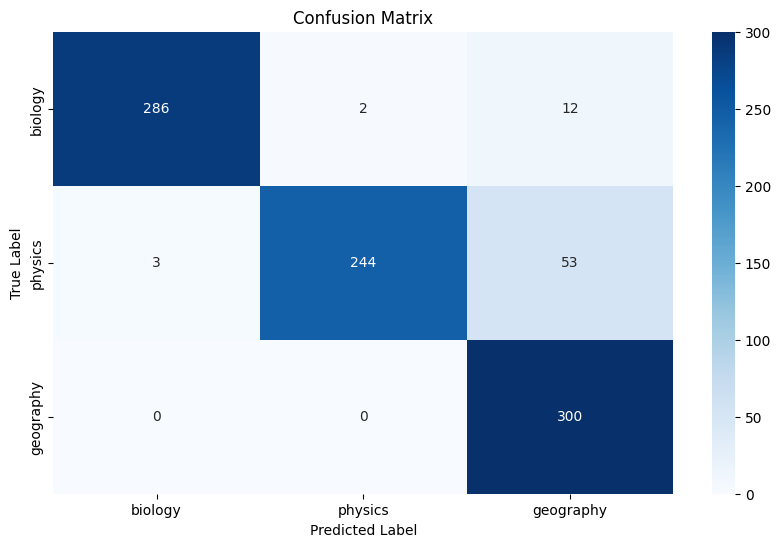

In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Classification report as a DataFrame
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
report_dict = classification_report(test['target'], y_pred, target_names=test['target_names'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Display nicely formatted classification report
print("Classification Report:")
display(report_df.style.background_gradient(cmap='Blues').format(precision=2))

# Confusion matrix visualization
cm = confusion_matrix(test['target'], y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test['target_names'], yticklabels=test['target_names'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
print("Confusion Matrix:")
plt.show()

**1st Model Performance & Error Analysis**

*Task: 3-way topic classification (biology / physics / geography)*

*Inputs: question + answer + hint + solution + lecture*

*Training: 300 examples/class, 1 epoch, LR = 2e-5, batch 8 (train) / 16 (eval), fp16*


---

#### Overall Metrics

* **Accuracy:** 0.92
* **Macro-avg F1:** 0.92
* **Weighted-avg F1:** 0.92

The model correctly labels 92% of held-out questions—very solid for a quick single-epoch fine-tune.

---

#### Class-Level Breakdown

| Class         | Precision | Recall | F1-score | Support |
| ------------- | --------- | ------ | -------- | ------- |
| **biology**   | 0.99      | 0.95   | 0.97     | 300     |
| **physics**   | 0.99      | 0.81   | 0.89     | 300     |
| **geography** | 0.82      | 1.00   | 0.90     | 300     |

* **Biology:**

  * High precision/recall—only 14 biology questions mis-labeled (12 → geography, 2 → physics).
* **Physics:**

  * Excellent precision but recall 0.81: the model misses \~19% of physics questions, often calling them geography (53 mis-labels).
* **Geography:**

  * Perfect recall (all 300 geography examples caught), but precision is 0.82: \~18% of non-geography questions get (incorrectly) “geography.”

---

#### Confusion Matrix Snippet

| True \ Pred   | biology | physics | geography |
| ------------- | ------- | ------- | --------- |
| **biology**   | 286     | 2       | 12        |
| **physics**   | 3       | 244     | 53        |
| **geography** | 0       | 0       | 300       |

* The biggest error mode is **over-predicting geography** for biology/physics.
* Geography’s strong patterns (e.g. map‐based hints) are learned quickly, but bleed into others.

---

#### What This Tells Us

1. **Strong baseline**: One epoch gets you 92% with minimal tuning.
2. **Recall vs. Precision trade-off**:

   * The model is maximizing recall for geography and precision for physics. We could tweak class weights or threshold to get a different balance.
3. **Error focus**:

   * Most mistakes are labeling biology/physics as geography → consider adding more non-geography cues or balancing examples.

---

#### Next Steps

* **More epochs** (2–4): let BERT refine its classification head.
* **Learning rate sweep**: try 3e-5 or warmup + decay schedule.
* **Class-weighted loss** or **focal loss**: penalize over­predicting geography.
* **Feature pruning**: drop long “lecture”/“solution” fields if they dilute the question signal.
* **Data augmentation**: paraphrase questions for physics/biology to diversify patterns.


### 2nd Model

Task: **Topic Classification**

Labels: **['biology', 'physics', 'geography', 'writing-strategies', 'figurative-language', 'chemistry', 'earth-science']**

Data consisted of these fields: **['question']**

Training Size: **300 records per topic** 

Validation Size: **200 records per topic** 

Training arguments: 
- num_train_epochs=1,                    # Epochs - start with fewer epochs for fast training
- per_device_train_batch_size=8,         # Small batch size due to limited GPU memory
- per_device_eval_batch_size=16,         # Larger batch size for evaluation
- gradient_accumulation_steps=4,         # Accumulate gradients to simulate a larger batch size
- eval_strategy="steps",                 # Evaluate at the end of every epoch
- save_strategy="steps",                 # Evaluate at the end of every epoch
- logging_dir="./logs",                  # Directory for logging
- logging_steps=10,                     # Log every 100 steps
- learning_rate=2e-5,                    # Standard learning rate for fine-tuning BERT
- weight_decay=0.01,                     # Regularization to prevent overfitting
- adam_epsilon=1e-8,                     # Adam optimizer epsilon
- fp16=True,                             # Enable mixed precision (FP16)
- load_best_model_at_end=True,           # Load the best model based on evaluation metrics
- metric_for_best_model="eval_loss",      # Choose evaluation metric to monitor for early stopping
- dataloader_num_workers=2,              # Use a couple of workers for data loading (adjust based on CPU cores)
- dataloader_pin_memory=True            # Pin memory for faster data loading

In [173]:
model_path = './models/7-labels-bert'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

In [113]:
predict('the distance between two points is 10km, I am traveling from point A to point B at a speed of 5km/h. How much time do I need to get from point A to point B?')

'physics'

In [114]:
predict('Effective writing strategies include planning, drafting, revising, and editing to clearly communicate ideas and engage the reader.')

'writing-strategies'

In [ ]:
test = prepare_dataset_for_classification(
    dataset, 
    "test", 
    "topic", 
    ['biology', 'physics', 'geography', 'writing-strategies', 'figurative-language', 'chemistry', 'earth-science'],
    ['question'],
    shuffle=True,
    random_state=None,
    max_items_per_class=300
)

testDataset = Dataset.from_dict({
    'text': test['data'],
    'label': test['target']
})

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True,)

tokenized_testingData = testDataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1901 [00:00<?, ? examples/s]

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments()

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\chris\AppData\Local\Temp\ipykernel_16920\2473200559.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [106]:
preds = trainer.predict(tokenized_testingData)

Classification Report:


,precision,recall,f1-score,support
biology,0.98,0.85,0.91,300.00
physics,0.94,0.83,0.88,300.00
geography,0.94,1.00,0.97,300.00
writing-strategies,0.84,0.77,0.81,300.00
figurative-language,0.77,0.91,0.83,267.00
chemistry,0.92,0.97,0.95,213.00
earth-science,0.87,0.94,0.90,221.00
accuracy,0.89,0.89,0.89,0.89
macro avg,0.89,0.90,0.89,1901.00
weighted avg,0.90,0.89,0.89,1901.00


Confusion Matrix:


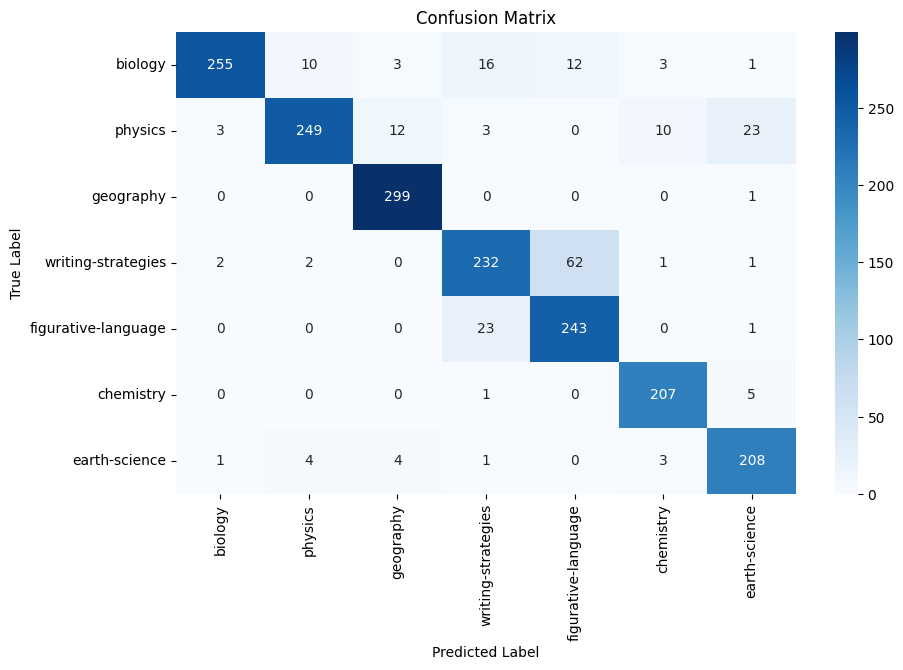

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Classification report as a DataFrame
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
report_dict = classification_report(test['target'], y_pred, target_names=test['target_names'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Display nicely formatted classification report
print("Classification Report:")
display(report_df.style.background_gradient(cmap='Blues').format(precision=2))

# Confusion matrix visualization
cm = confusion_matrix(test['target'], y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test['target_names'], yticklabels=test['target_names'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
print("Confusion Matrix:")
plt.show()

#### **Overall Performance**
- Accuracy: 89% – Your model is performing well, correctly classifying nearly 9 out of 10 examples.
- Macro F1-score: 0.89 – High and balanced performance across all classes, regardless of class size.
- Weighted F1-score: 0.89 – Good overall performance, taking class distribution into account.

#### **Strongest Classes:**
- Geography: Near-perfect recall (1.00) and high F1 (0.97) – your model consistently predicts this well.
- Chemistry & Earth-science: Excellent F1-scores and recall, indicating accurate and consistent predictions.

#### **Moderate Classes:**
- Biology & Physics: High precision but slightly lower recall – model is cautious but occasionally misses true positives.

#### **Weaker Classes:**
- Writing-strategies & Figurative-language: Lower precision/recall – these are likely harder for the model due to overlap in language or less distinct patterns.

#### **Performance Efficiency**
- Runtime: ~162s, ~11.7 samples/sec – reasonable for evaluation with BERT on ~1900 examples.

#### **Final Takeaways:**
- The model generalizes well across most classes.
- A few underperforming classes (e.g. figurative-language, writing-strategies) may benefit from:
    - More training samples
    - Better feature engineering
    - Data augmentation
    - Class-specific fine-tuning

### 3rd Model

Task: **Topic Classification**

Labels: **['biology', 'physics', 'geography', 'writing-strategies', 'figurative-language', 'chemistry', 'earth-science']**

Data consisted of these fields: **['question', 'answer', 'hint', 'solution', 'lecture']**

Training Size: **300 records per topic** 

Validation Size: **200 records per topic** 

training arguments: 
- num_train_epochs=1,                    # Epochs - start with fewer epochs for fast training
- per_device_train_batch_size=8,         # Small batch size due to limited GPU memory
- per_device_eval_batch_size=16,         # Larger batch size for evaluation
- gradient_accumulation_steps=4,         # Accumulate gradients to simulate a larger batch size
- eval_strategy="steps",                 # Evaluate at the end of every epoch
- save_strategy="steps",                 # Evaluate at the end of every epoch
- logging_dir="./logs",                  # Directory for logging
- logging_steps=10,                     # Log every 100 steps
- learning_rate=2e-5,                    # Standard learning rate for fine-tuning BERT
- weight_decay=0.01,                     # Regularization to prevent overfitting
- adam_epsilon=1e-8,                     # Adam optimizer epsilon
- fp16=True,                             # Enable mixed precision (FP16)
- load_best_model_at_end=True,           # Load the best model based on evaluation metrics
- metric_for_best_model="eval_loss",      # Choose evaluation metric to monitor for early stopping
- dataloader_num_workers=2,              # Use a couple of workers for data loading (adjust based on CPU cores)
- dataloader_pin_memory=True            # Pin memory for faster data loading

In [175]:
model_path = './models/7-labels-bert-b'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

In [176]:
predict('the distance between two points is 10km, I am traveling from point A to point B at a speed of 5km/h. How much time do I need to get from point A to point B?')

'geography'

In [177]:
predict('Effective writing strategies include planning, drafting, revising, and editing to clearly communicate ideas and engage the reader.')

'writing-strategies'

In [178]:
test = prepare_dataset_for_classification(
    dataset, 
    "test", 
    "topic", 
    ['biology', 'physics', 'geography', 'writing-strategies', 'figurative-language', 'chemistry', 'earth-science'],
    ['question'],
    shuffle=True,
    random_state=None,
    max_items_per_class=300
)

testDataset = Dataset.from_dict({
    'text': test['data'],
    'label': test['target']
})

In [179]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True,)

tokenized_testingData = testDataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1901 [00:00<?, ? examples/s]

In [180]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments()

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\chris\AppData\Local\Temp\ipykernel_16920\1057010216.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [181]:
preds = trainer.predict(tokenized_testingData)

Classification Report:


,precision,recall,f1-score,support
biology,0.38,0.13,0.19,300.00
physics,0.00,0.00,0.00,300.00
geography,0.20,1.00,0.34,300.00
writing-strategies,0.23,0.15,0.18,300.00
figurative-language,0.66,0.24,0.35,267.00
chemistry,1.00,0.05,0.09,213.00
earth-science,0.14,0.00,0.01,221.00
accuracy,0.24,0.24,0.24,0.24
macro avg,0.37,0.22,0.16,1901.00
weighted avg,0.35,0.24,0.17,1901.00


Confusion Matrix:


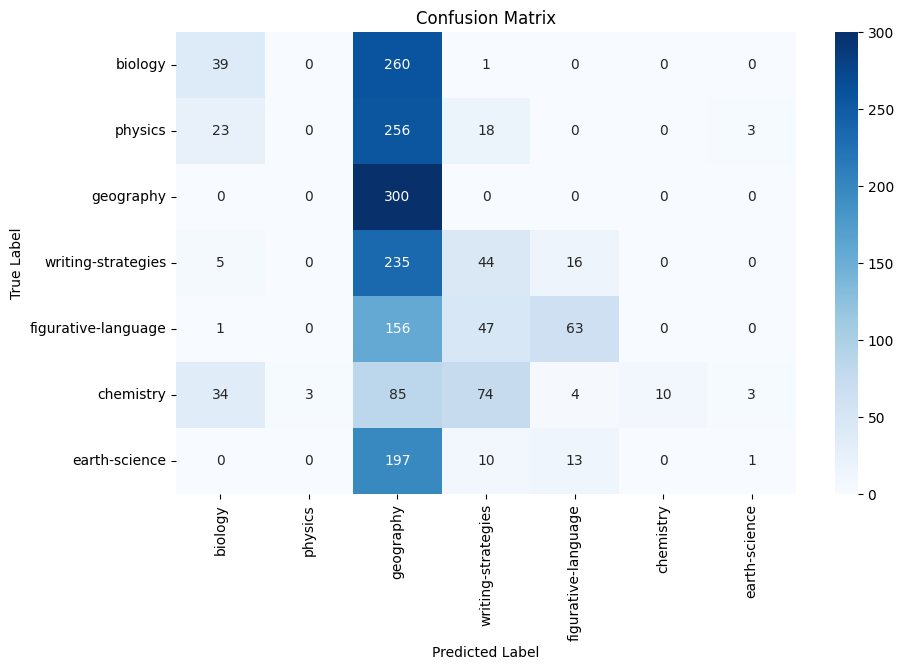

In [182]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Classification report as a DataFrame
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
report_dict = classification_report(test['target'], y_pred, target_names=test['target_names'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Display nicely formatted classification report
print("Classification Report:")
display(report_df.style.background_gradient(cmap='Blues').format(precision=2))

# Confusion matrix visualization
cm = confusion_matrix(test['target'], y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test['target_names'], yticklabels=test['target_names'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
print("Confusion Matrix:")
plt.show()

**Analysis of 3rd Model’s Performance**

---

#### 1. **Overall Metrics**

* **Accuracy: 0.24**
  Out of 7 classes, the model only gets about **24%** of examples correct—barely above random chance (≈ 1/7 ≈ 14%).

* **Macro Avg F1: 0.16**
  Averaging unweighted across all classes, the model’s F1 is extremely low, indicating poor per-class performance.

* **Weighted Avg F1: 0.17**
  Even accounting for class support, the model struggles overall.

---

#### 2. **Class-by-Class Breakdown**

| Class                   | Precision | Recall | F1-score | Support |
| ----------------------- | --------- | ------ | -------- | ------- |
| **biology**             | 0.38      | 0.13   | 0.19     | 300     |
| **physics**             | 0.00      | 0.00   | 0.00     | 300     |
| **geography**           | 0.20      | 1.00   | 0.34     | 300     |
| **writing-strategies**  | 0.23      | 0.15   | 0.18     | 300     |
| **figurative-language** | 0.66      | 0.24   | 0.35     | 267     |
| **chemistry**           | 1.00      | 0.05   | 0.09     | 213     |
| **earth-science**       | 0.14      | 0.00   | 0.01     | 221     |

* **Geography**

  * **Recall = 1.00**: the model predicts *every* example as “geography,” so it never misses a geography instance.
  * **Precision = 0.20**: but 80% of its “geography” predictions are actually from other classes.
  * **F1 = 0.34**: the best among all classes, but still low.

* **Chemistry**

  * **Precision = 1.00**: every time it predicts “chemistry” (very rare), it’s correct.
  * **Recall = 0.05**: it predicts “chemistry” almost never, missing 95% of true chemistry examples.

* **Physics & Earth-Science**

  * Both have **0 recall**, meaning the model never correctly predicts these classes.
  * Physics also has **0 precision**, so it never labels anything as physics at all.

* **Biology, Writing-Strategies, Figurative-Language**

  * All have modest precision but very low recall (< 25%), so they’re being under-predicted.

---

#### 3. **Confusion Matrix Patterns**

* **Monolithic Prediction**

  * The vast majority of *every* true class is predicted as **geography** (see the heavy column for geography).
  * True geography rows are perfectly predicted, which inflates geography’s recall to 100%.

* **Sparse Other Predictions**

  * A handful of biology, writing, or figurative-language predictions creep in, but they’re extremely rare.

---

#### 4. **Likely Causes**

1. **Collapsed to Majority Class**
   With 300 examples per class, the model has learned to output “geography” for everything—this “safe” strategy maximizes geography’s recall and overall accuracy initially.

2. **Underfitting**

   * **1 epoch** of training is insufficient for BERT to learn 7-way distinctions.
   * **Very small batch sizes** and heavy feature noise (long “lecture” or “solution” fields) may hamper learning.

3. **Imbalanced Learning Dynamics**
   Even though classes were balanced in sampling, the model isn’t getting enough signal to differentiate them.

---

#### 5. **What we could do to improve performance**

* **Train Longer**: Increase `num_train_epochs` to 3–5 to allow BERT to adapt its classification head.
* **Adjust Learning Rate**: You might need a slightly higher LR (e.g., 3e-5) for faster convergence.
* **Prune Inputs**: Use only the **most informative fields** (e.g., question + answer), drop lengthy “lecture”/“solution” text that may drown out the signal.
* **Use Class Weights or Focal Loss**: Penalize mistakes on under-predicted classes to force the model to learn their patterns.
* **Data Augmentation**: Paraphrase or expand examples for weak classes, so the model sees more varied language.

---

**Bottom Line**:
The model has effectively **memorized one class (“geography”)** as a shortcut. To get a real 7-way classifier, you need more training signal—either via more epochs, better feature selection, stronger regularization, or richer data.
